# Generative linear models para ver tendencias de COVID-19 en Chile

In [388]:
#Cargamos datos
import pandas as pd

df = pd.read_excel('casos_n.xls').reset_index().rename(columns={1: 'new_cases', 'index': 'day'})
df['total_cases'] = df.new_cases.cumsum()

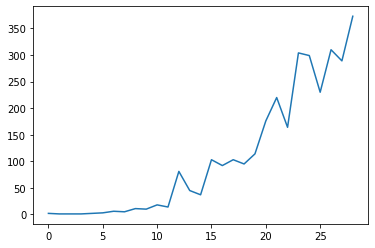

In [389]:
# Los miramos en el grafico
df.new_cases.plot()

In [390]:
# Preparamos X, y
X = np.expand_dims(df.day.to_numpy(), 1)
y = df.new_cases

In [391]:
# FUERA DE USO
# Alternativa para hacer grid search de splines

#gam = LinearGAM(n_splines=25,spline_order=3)
#gam.gridsearch(X, y, n_splines=np.arange(50))

In [392]:
# FUERA DE USO
# Alternativa para hacer grid search de lambadas

#gam = LinearGAM(n_splines=4,spline_order=3).gridsearch(X, y, lam=np.logspace(-12, 12, 5000))

In [393]:
from pygam import LinearGAM, s, f

# Definimos nuetras GAM como una linear de spline(X) + spline(X)
gam = LinearGAM(s(0, n_splines=20))

In [394]:
# Hacemos fit
gam.fit(X, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

In [395]:
# Un sumario

gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                       8.176
Link Function:                     IdentityLink Log Likelihood:                                  -221.4142
Number of Samples:                           29 AIC:                                              461.1804
                                                AICc:                                             471.1012
                                                GCV:                                             1617.2466
                                                Scale:                                             825.178
                                                Pseudo R-Squared:                                   0.9558
Feature Function                  Lam

<ipython-input-395-4bebcc94ea8e>:3: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


### Ploteamos las predicciones para para el modelo y sus intervalos

In [396]:
# Pongamos fechas bonitas
import datetime

def nday2datetime(nday):
    base_date = datetime.datetime(2020, 3, 2)
    return base_date + datetime.timedelta(days=nday)

def nday2datetime_list(nday_list):
    result = []
    for nday in nday_list:
        result.append(nday2datetime(nday))
        
    return result


df['ds'] = df.day.apply(nday2datetime)
#df.set_index('ds');

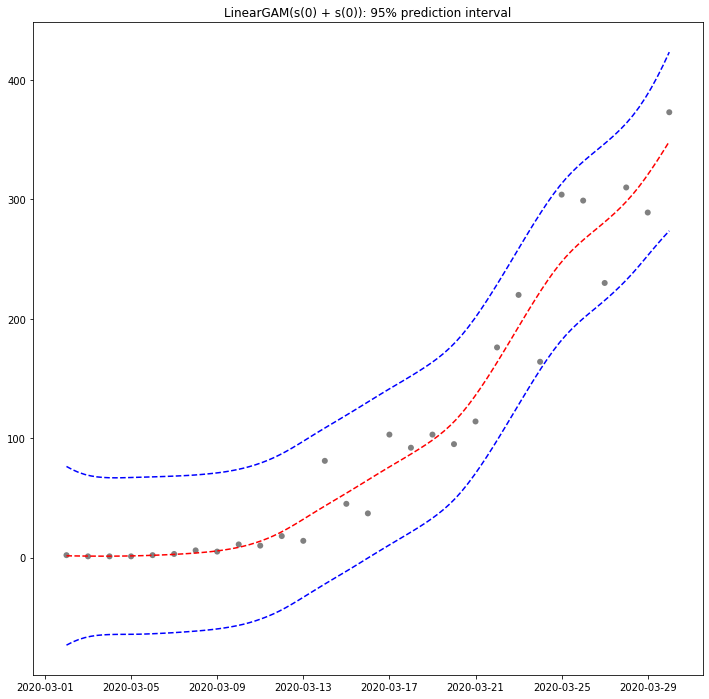

In [398]:
import matplotlib.pyplot as plt

def plot_gam(gam, title, X, y, save = False):
    plt.figure(figsize=(12, 12));

    XX = gam.generate_X_grid(0)

    plt.plot(nday2datetime_list(XX[:, 0]), gam.predict(XX), 'r--')
    plt.plot(nday2datetime_list(XX[:, 0]), gam.prediction_intervals(XX), color='b', ls='--')

    plt.scatter(X, y, facecolor='gray', edgecolors='none')
    plt.title(title)
    if save:
        plt.savefig(f'{title}.png')
    plt.show()
    plt.close()
        
plot_gam(gam, 'LinearGAM(s(0) + s(0)): 95% prediction interval', df.ds, y)

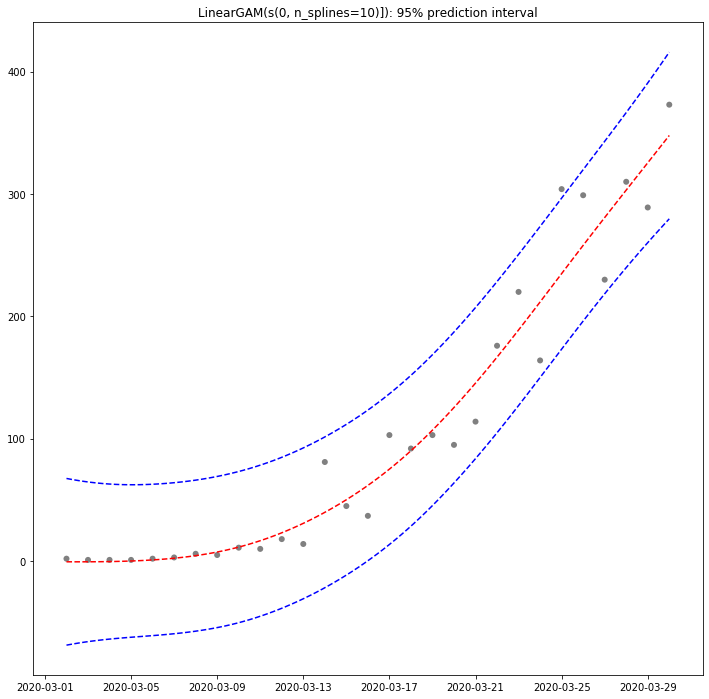

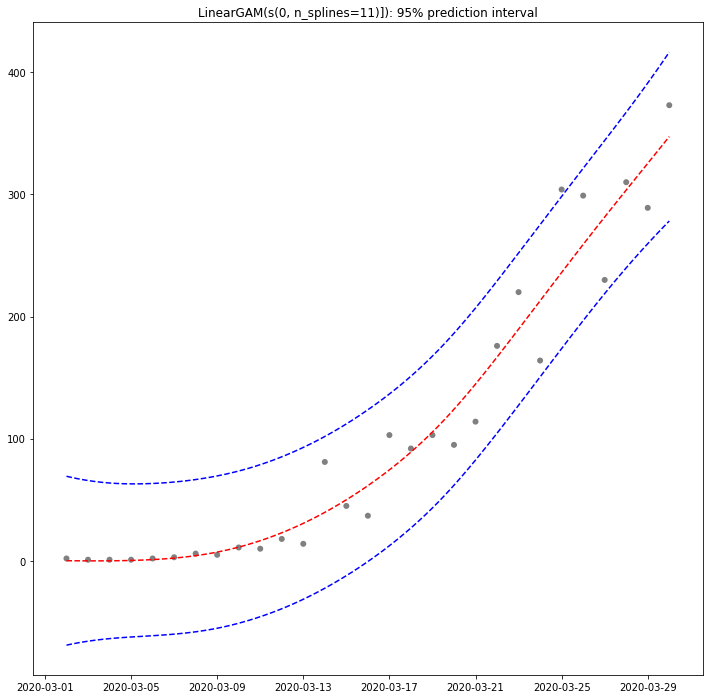

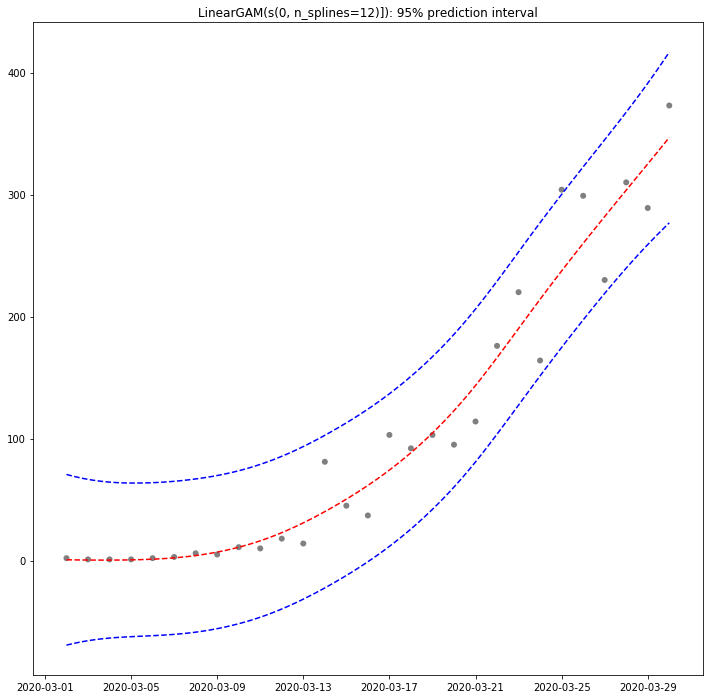

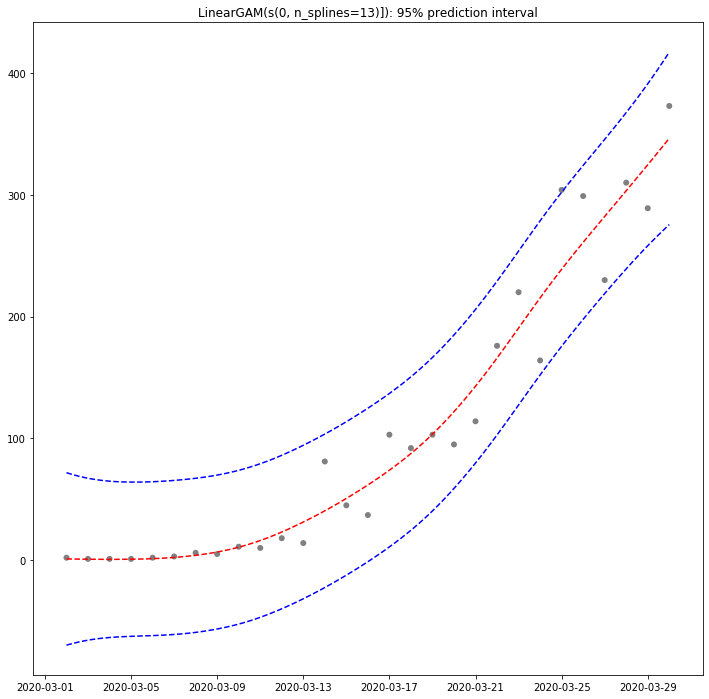

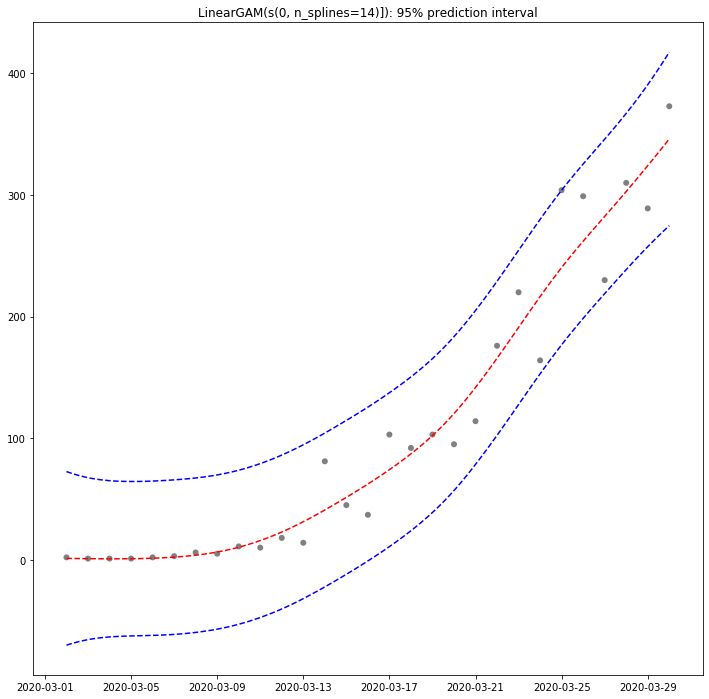

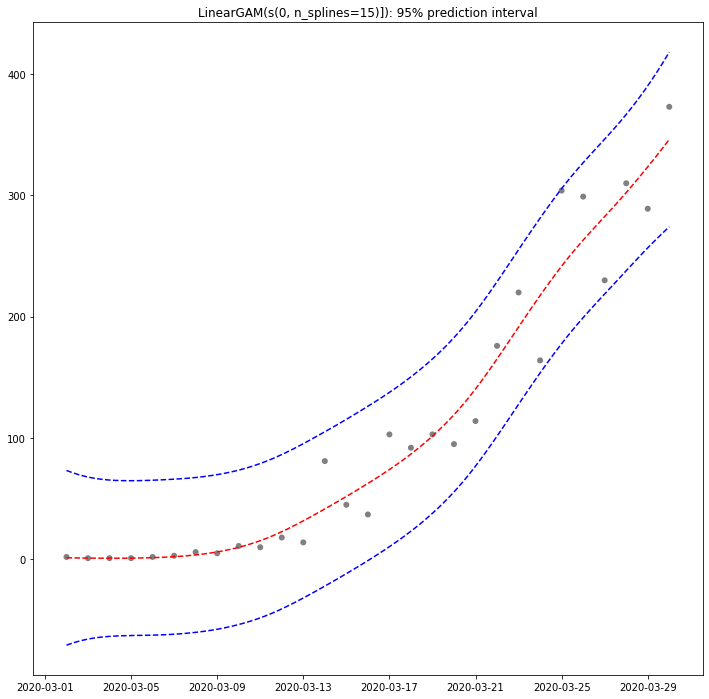

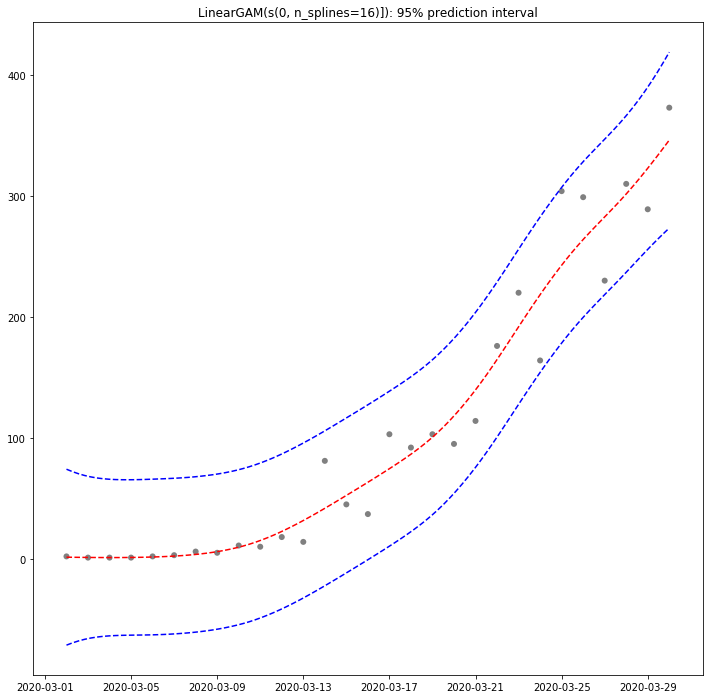

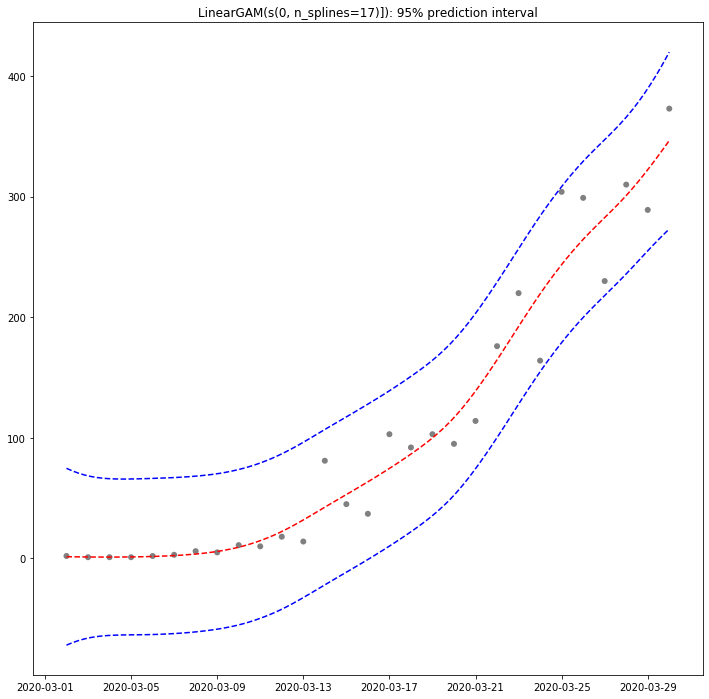

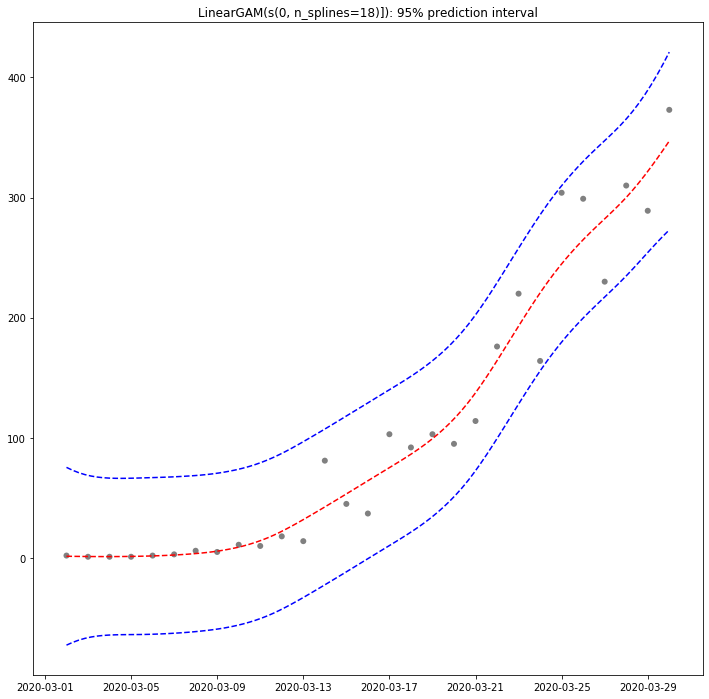

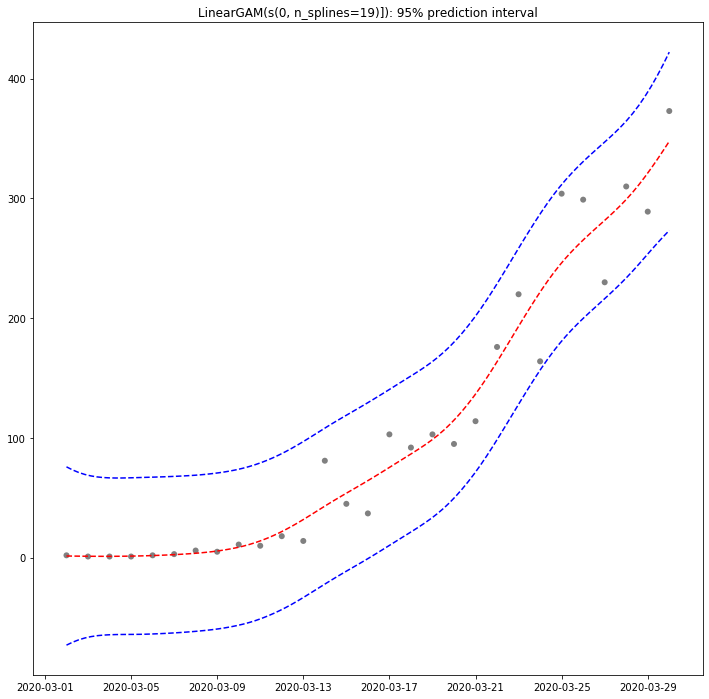

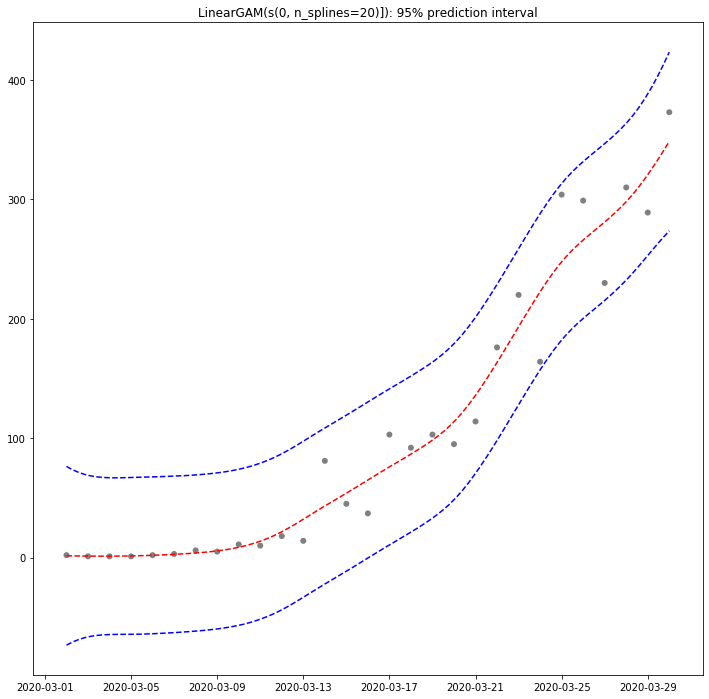

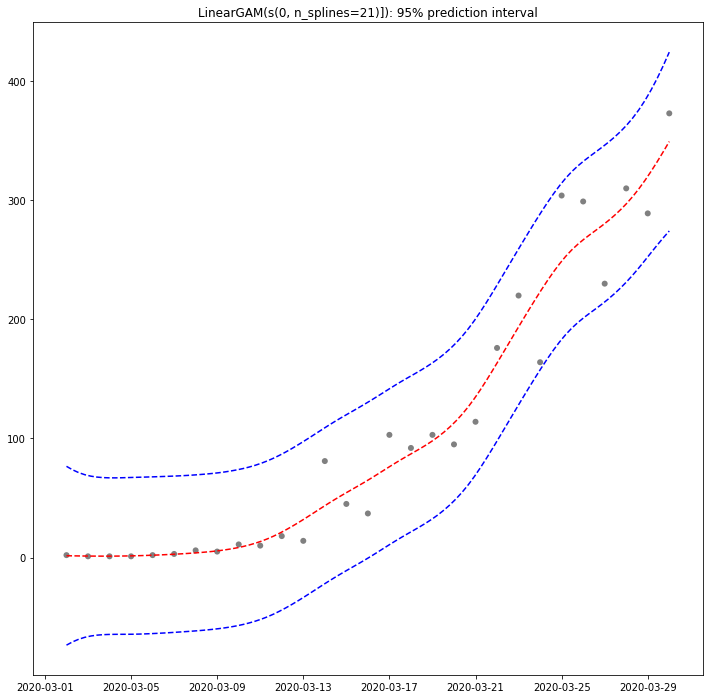

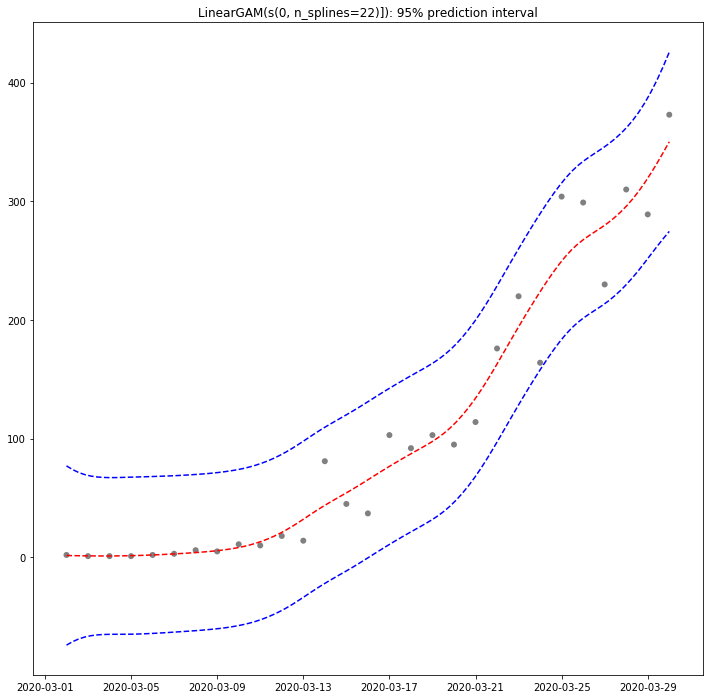

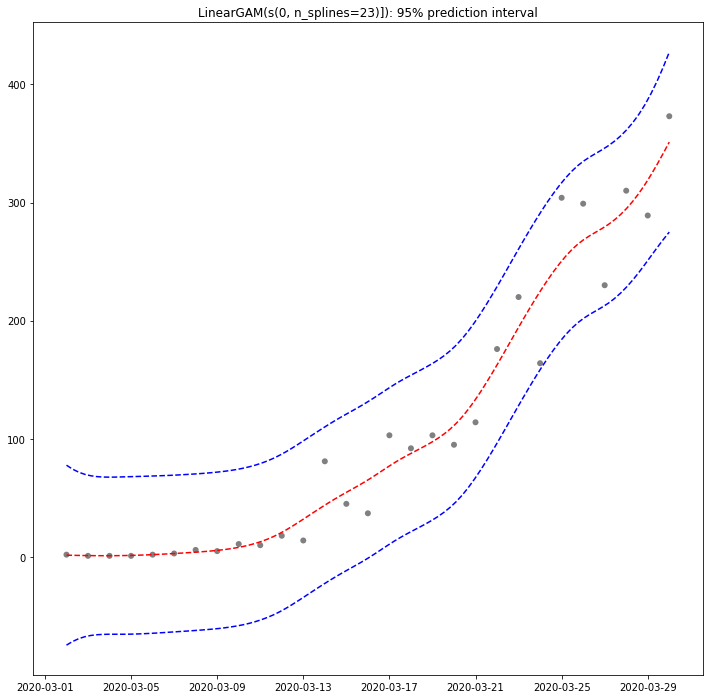

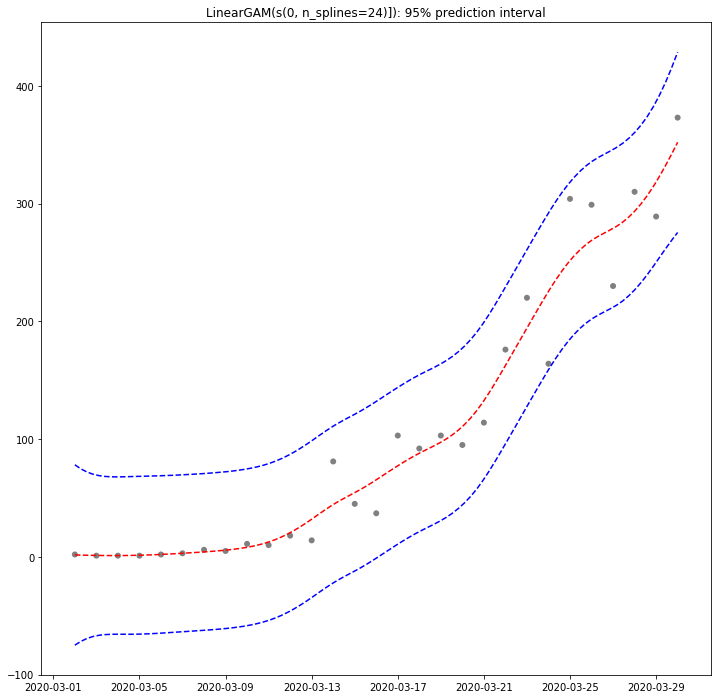

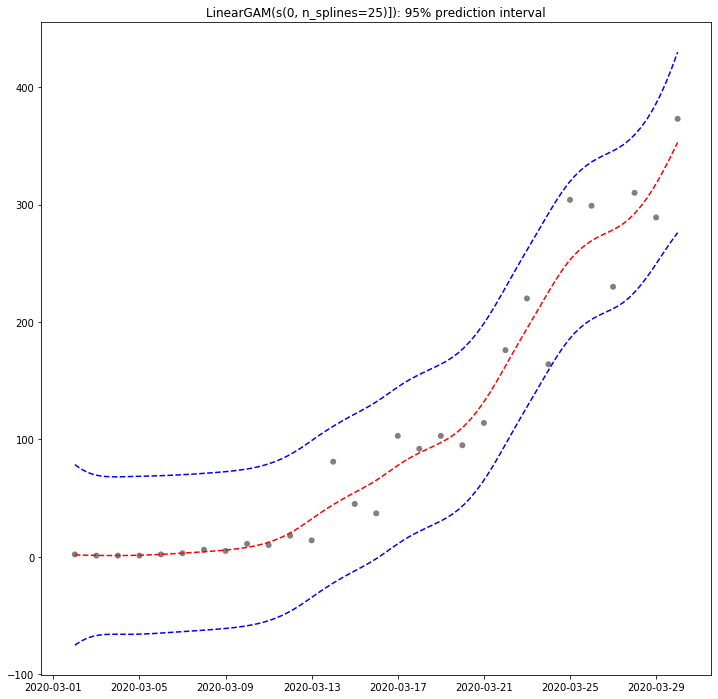

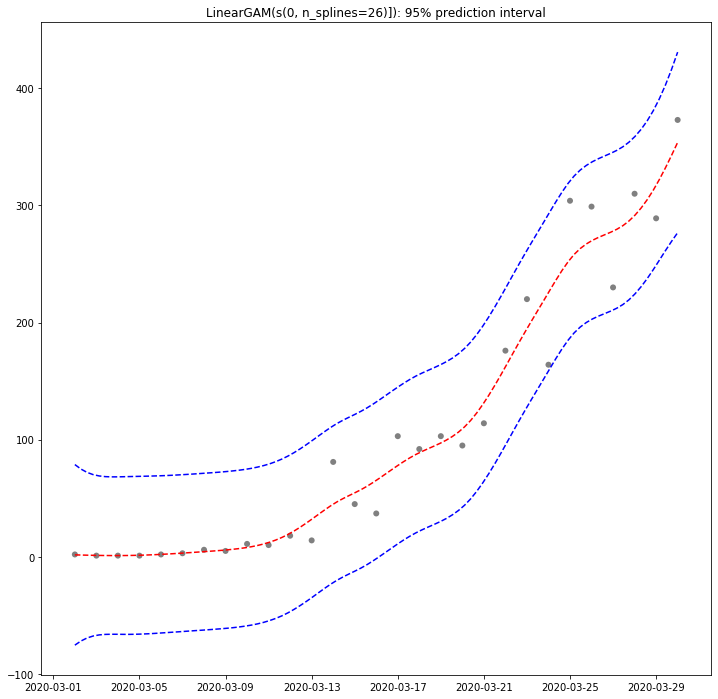

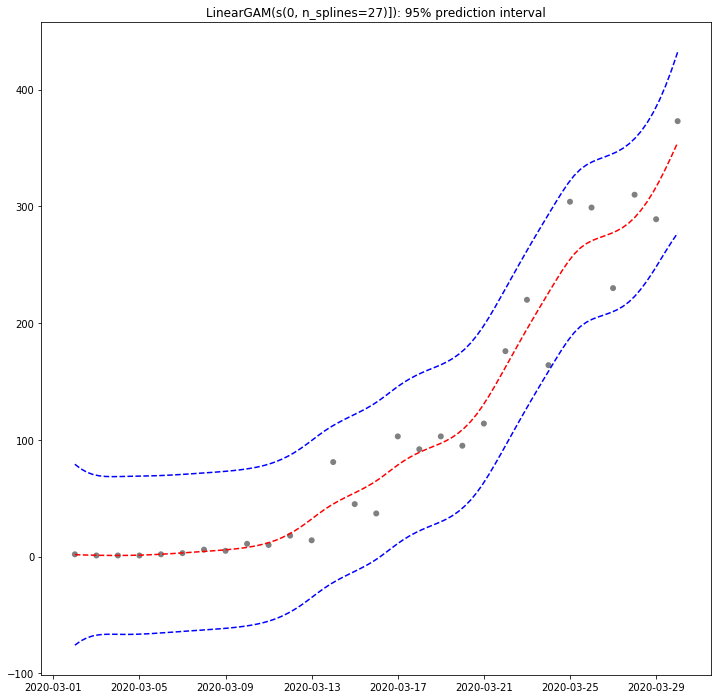

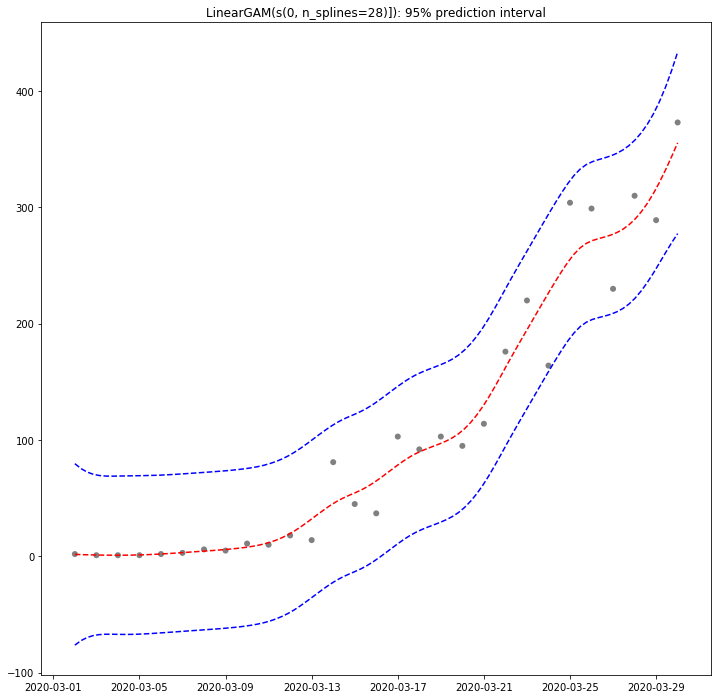

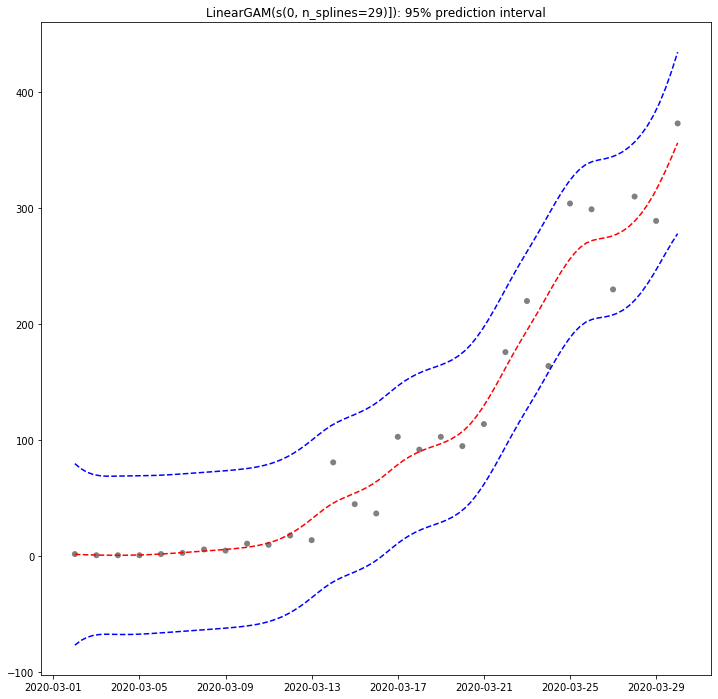

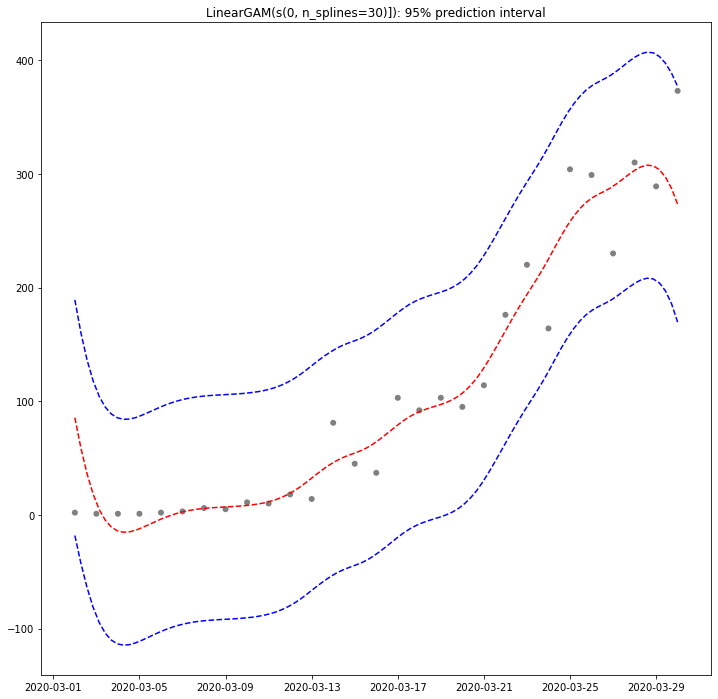

In [399]:
# Miremos un rango
# Veremos modelos muy generales donde no se pueden ver sub-tendencias clararas por un lado
# y modelos overfited por el otro donde cada variación se sobre interpreta mucho.
# La idea es entender como se comporta el modelo en un rango de hiper-parametros

for n_splines in range(10, 31):
    gam = LinearGAM(s(0, n_splines=n_splines))
    gam.fit(X, y)
    plot_gam(gam, f'LinearGAM(s(0, n_splines={n_splines})]): 95% prediction interval', df.ds, y, True)

In [237]:
# Miremos los coeficientes
gam.coef_

array([-97.21975061, -97.77123722, -98.18299062, -97.9151746 ,
       -96.8138168 , -95.13516232, -91.82219341, -83.3872797 ,
       -66.16482731, -47.73786847, -31.31050243, -13.19718771,
         2.40167209,  34.12816377,  84.45137804, 134.00697618,
       172.38187048, 185.74294362, 196.69171775, 206.08639412,
        99.23312606])